In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys, math
from tqdm.auto import tqdm
import copy

import csv
import re

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from einops import rearrange, reduce, repeat

In [ ]:
import lovely_tensors as lt
lt.monkey_patch()

In [4]:
import parser
import longrange
import dataset
import util
import train
import evaluate

In [7]:
ds = dataset.load_dataset(tqdm=tqdm)

Found existing dataset at ../data/datasets.pkl


In [17]:
list(ds[0].items())[0]

('../data/Gutenberg/txt/Charlotte Mary Yonge___The Chosen People.txt',
 {'ids': array([ 10,  84,  72, ..., 101,  46,  10], dtype=uint8),
  'fbin_fchars': array([-2,  0, -2, ..., -2, -2, -2], dtype=int8)})

In [4]:
net = longrange.LongRangeGPT(**longrange.get_config("longrange2"))

In [5]:
x = torch.randint(0, 128, (1, 256))
memory = torch.randn(1, 256, 384)
logits, memory_out = net.forward(x, memory_in=memory, calc_memory_out=True)
logits.shape#, memory_out.shape

torch.Size([1, 256, 128])

In [8]:
ids_book = parser.book2ids()

In [5]:
ds_train, ds_test = dataset.load_dataset(tqdm=tqdm)

Found existing dataset at ../data/datasets.pkl


In [51]:
np.random.seed(1)
torch.manual_seed(0)
for (a, b), (c, d) in dataset.get_seq_batches(ds_train, 1, 10, 2, 50, 0, 1):
    print(parser.ids2text(a[0]).replace('\n', ' '), end='|')
    print(parser.ids2text(b[0]).replace('\n', ' '), end='|')
    print()
    print(''.join(['_' if i==-2 else str(i) for i in c[0].tolist()]), end='|')
    print(''.join(['_' if i==-2 else str(i) for i in d[0].tolist()]), end='|')

ker neighbors only fled from their immediate vicin|ity to return again when the danger was past. With|
____7_________2____8____1____2_____6_________8____|____0__4______4_____2____0___7______2___4_____1___|

In [168]:
for (a, ), (b, ) in dataset.get_seq_batches(ds_train, 1, 1000, 1, 500, 0, 1):
    for i in range(-2, 10):
        print(f'{i=}, {(b==i).sum().item()}/{b.numel()}')

i=-2, 408367/500000
i=-1, 720/500000
i=0, 15831/500000
i=1, 13103/500000
i=2, 15053/500000
i=3, 8629/500000
i=4, 6150/500000
i=5, 7219/500000
i=6, 6984/500000
i=7, 8434/500000
i=8, 9510/500000
i=9, 0/500000


In [86]:
class RunningMean():
    def __init__(self):
        self.n = 0
        self.mean = 0
    def update(self, x, n=1):
        self.mean = (self.mean*self.n + x*n)/(self.n + n)
        self.n += n
    def get(self):
        return self.mean

In [59]:
config_net = longrange.get_config('transformer')
net = longrange.LongRangeGPT(**config_net)

In [266]:
from einops import rearrange

In [270]:



np.random.seed(1)
torch.manual_seed(0)
net = longrange.LongRangeGPT(**longrange.get_config('transformer'))
loss_mean, loss_count = evaluate_net(net, ds_test, 100, 8, 1, 20)

100%|██████████| 100/100 [00:05<00:00, 16.91it/s]


In [271]:
loss_mean, loss_count

(tensor[1, 19, 11] n=209 x∈[0., 6.350] μ=4.850 σ=0.930,
 tensor[1, 19, 11] n=209 x∈[1.000, 667.000] μ=73.727 σ=184.072)

In [268]:
loss_mean

tensor[4, 19, 11] n=836 x∈[0., 6.191] μ=4.915 σ=0.866

In [269]:
for i_seq in range(len(loss_mean)):
    print(i_seq, loss_mean[i_seq])
    wandb.log({f'viz_ppl seq {i_seq}': wandb.Image(viz_ppl(loss_mean[i_seq], loss_count[i_seq]))})

0 tensor[19, 11] n=209 x∈[0., 5.883] μ=4.889 σ=0.927
1 tensor[19, 11] n=209 x∈[0., 6.073] μ=4.946 σ=0.801
2 tensor[19, 11] n=209 x∈[0., 5.760] μ=4.892 σ=0.862
3 tensor[19, 11] n=209 x∈[0., 6.191] μ=4.932 σ=0.874


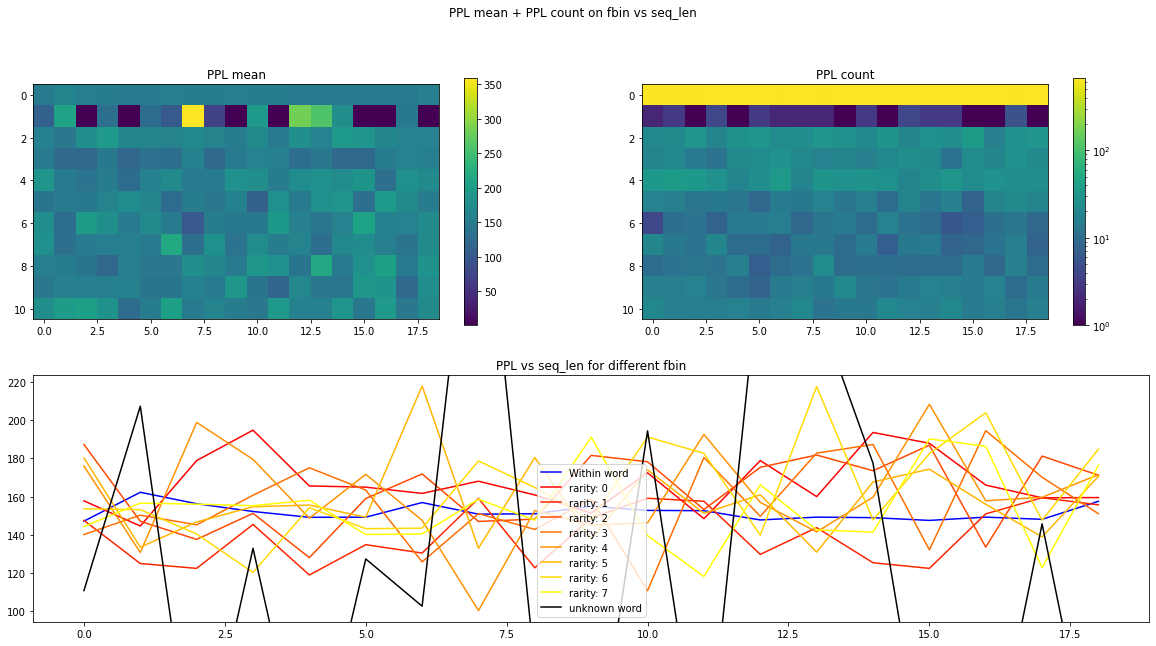

In [265]:
fig = viz_ppl(loss_mean[0, ...], loss_count[0, ...])
plt.show()

In [49]:
batch1, batch2 = next(dataset.get_random_skip_batches(a, 1, 128, 256))

In [52]:
longrange.loss_fn_longrange(net, batch1.long(), batch2.long())

tensor(4.9990, grad_fn=<DivBackward0>)

In [91]:
block = transformer.Block(dict(n_embd=384, n_head=1, attn_pdrop=.1, resid_pdrop=.1))

In [92]:
x = torch.randn(1, 10, 384)
y = torch.randn(1, 20, 384)
nx, ny = x.shape[-2], y.shape[-2]
mask = ~torch.tril(torch.ones(nx, ny, device=x.device), diagonal=ny-nx).to(bool)
a, b = block.attn(x, y, y, attn_mask=mask)
a.shape, b.shape

(torch.Size([1, 10, 384]), torch.Size([1, 10, 20]))

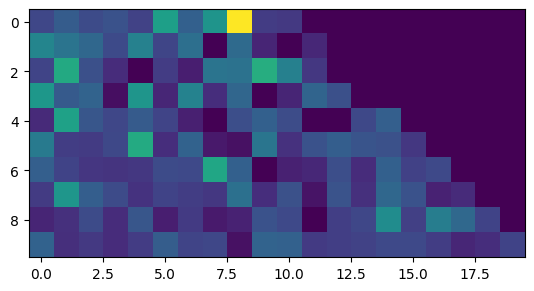

In [93]:
plt.imshow(b[0].detach().numpy())

In [444]:
def calc_fbin2wordset(word2freq, n_bins=9, strategy='naive'):
    # in a frequency vs word rank chart
    # split evenly on x-axis
    if strategy=='naive':
        fbin2wordset = [set(word_set) for word_set in np.split(words, n_bins)]
    # split evenly on y-axis
    elif strategy=='normal':
        bins = np.logspace(np.log(freqs[0])+1e-5, np.log(freqs[-1])-1e-5, num=n_bins+1, base=np.e)
        fbin2wordset = [{word for word, freq in word2freq.items() if a>=freq and freq>b} for a, b in zip(bins[:-1], bins[1:])]
    # split such that each bin has the same probability
    elif strategy=='uniform':
        binprob = 1./n_bins
        fbin2wordset = []
        wordset, cbinprob = set(), 0.
        for word, freq in word2freq.items():
            wordset.add(word)
            cbinprob += freq
            if cbinprob>=binprob:
                fbin2wordset.append(wordset)
                wordset, cbinprob = set(), 0.
        if wordset:
            fbin2wordset.append(wordset)
    return fbin2wordset
        
        
from collections import defaultdict
word2count = {}
with open('../data/unigram_freq.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for word, count in tqdm(reader):
        if count.isnumeric():
            word2count[word.lower()] = int(count)
n_total_words = np.sum(list(word2count.values()))
words, wordset = np.array(list(word2count.keys())), set(word2count.keys())
word2freq = {word: count/n_total_words for word, count in word2count.items()}
counts, freqs = np.array(list(word2count.values())), np.array(list(word2freq.values()))

fbin2wordset = calc_fbin2wordset(word2freq, strategy='uniform')

print(sum([len(a) for a in fbin2wordset]))
assert sum([len(a) for a in fbin2wordset]) == len(word2freq)
word2fbin = defaultdict(lambda : -1)
word2fbin.update({word: fbin for fbin, wordset in enumerate(fbin2wordset) for word in wordset})

0it [00:00, ?it/s]

333333


Text(0.5, 0, 'bin number')

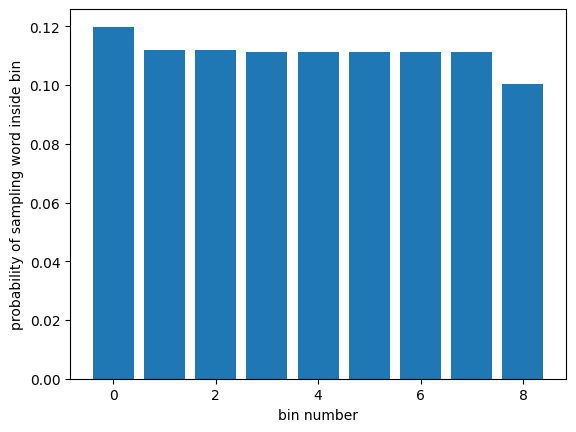

In [445]:
a = [sum([word2freq[word] for word in a]) for a in fbin2wordset]
plt.bar(np.arange(len(a)), a)
plt.ylabel('probability of sampling word inside bin')
plt.xlabel('bin number')

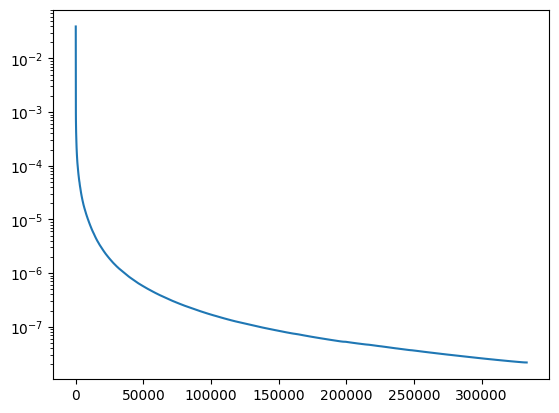

In [408]:
plt.plot(freqs)
plt.yscale('log')
# plt.xscale('log')

In [232]:
text_book = parser.book2text('../data/Gutenberg/txt/Abraham Lincoln___Lincoln Letters.txt')

In [138]:
import nltk#.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /afs/csail.mit.edu/u/a/akumar01/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [301]:
def tokenize(txt):
    tokens = nltk.tokenize.word_tokenize(txt)
    idxs = []
    offset = 0
    for token in tokens:
        offset = txt.find(token, offset)
        idxs.append(offset)
        offset += len(token)
    tokens, idxs = np.array(tokens), np.array(idxs)
    return tokens, idxs

def process_text(text):
    # we only want 32 to 126 inclusive
    possible_chrs = {ord('\n')}.union(set(range(32, 126+1)))
    
    # remove multiple spaces and multiple newlines
    text = re.sub(' +', ' ', text)
    text = re.sub('\n+', '\n', text)
    text = ''.join([a for a in text if ord(a) in possible_chrs])
    
    ids = np.array([ord(a) for a in text], dtype=np.uint8)
    
    words, idxs = tokenize(text.lower())
    
    fbins_words = np.array([word2fbin[word] for word in words])
    
    fbins_fchars = np.full(ids.shape, fill_value=-2, dtype=np.int8)
    fbins_fchars[idxs] = fbins_words
    
    # text, character ids
    # word tokens, locations of word tokens in text
    # frequency bin of each word
    # frequency bin of each (first character in word) and -2 for all other characters
    return text, ids, words, idxs, fbins_words, fbins_fchars


In [306]:
for book in tqdm(os.listdir('../data/Gutenberg/txt/')):
    text_book = parser.book2text(f'../data/Gutenberg/txt/{book}')
    text, ids, words, idxs, fbins_words, fbins_fchars = process_text(text_book)
    

  0%|          | 0/3037 [00:00<?, ?it/s]

KeyboardInterrupt: 

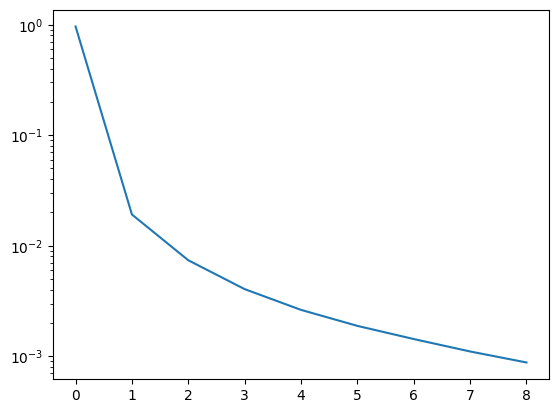

In [324]:
a = np.split(np.array(list(word2freq.values())), 9)
plt.plot([ai.sum() for ai in a])
plt.yscale('log')

Text(0, 0.5, 'frequency')

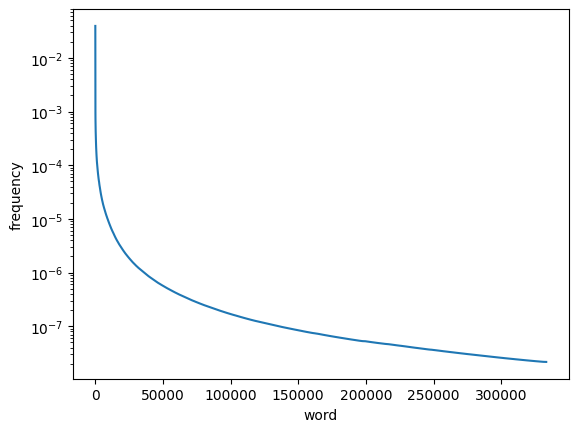

In [311]:
plt.plot(word2freq.values())
plt.yscale('log')
plt.xlabel('word')
plt.ylabel('frequency')

In [168]:
text_book[:1000]

'\nlincoln letters\n\nby abraham lincoln\n\n\npublished by the bibilophile society\n\n\n\n\nnote\n\nthe letters herein by lincoln are so thoroughly characteristic of\nthe man, and are in themselves so completely self-explanatory, that\nit requires no comment to enable the reader fully to understand and\nappreciate them. it will be observed that the philosophical\nadmonitions in the letter to his brother, johnston, were written on\nthe same sheet with the letter to his father.\n\nthe promptness and decision with which lincoln despatched the\nmultitudinous affairs of his office during the most turbulent\nscenes of the civil war are exemplified in his unequivocal order to\nthe attorney-general, indorsed on the back of the letter of hon.\naustin a. king, requesting a pardon for john b. corner. the\nindorsement bears even date with the letter itself, and corner was\npardoned on the following day.\n\n\nthe originals from which the within facsimiles were made are in the\ncollection of mr. wil

In [169]:
nltk.tokenize.word_tokenize(text_book[:1000])

['lincoln',
 'letters',
 'by',
 'abraham',
 'lincoln',
 'published',
 'by',
 'the',
 'bibilophile',
 'society',
 'note',
 'the',
 'letters',
 'herein',
 'by',
 'lincoln',
 'are',
 'so',
 'thoroughly',
 'characteristic',
 'of',
 'the',
 'man',
 ',',
 'and',
 'are',
 'in',
 'themselves',
 'so',
 'completely',
 'self-explanatory',
 ',',
 'that',
 'it',
 'requires',
 'no',
 'comment',
 'to',
 'enable',
 'the',
 'reader',
 'fully',
 'to',
 'understand',
 'and',
 'appreciate',
 'them',
 '.',
 'it',
 'will',
 'be',
 'observed',
 'that',
 'the',
 'philosophical',
 'admonitions',
 'in',
 'the',
 'letter',
 'to',
 'his',
 'brother',
 ',',
 'johnston',
 ',',
 'were',
 'written',
 'on',
 'the',
 'same',
 'sheet',
 'with',
 'the',
 'letter',
 'to',
 'his',
 'father',
 '.',
 'the',
 'promptness',
 'and',
 'decision',
 'with',
 'which',
 'lincoln',
 'despatched',
 'the',
 'multitudinous',
 'affairs',
 'of',
 'his',
 'office',
 'during',
 'the',
 'most',
 'turbulent',
 'scenes',
 'of',
 'the',
 'civil

In [162]:
for word in nltk.tokenize.word_tokenize(text_book):
    if word not in wordset:
        print(word)

bibilophile
,
self-explanatory
,
.
,
,
.
attorney-general
,
.
a.
,
b.
.
,
.
mr.
k.
,
[
:
01
]
[
:
02
]
[
:
03
]
,
dec.
24th
,
1848.
:
--
7th
.
,
.
;
,
.
,
;
,
,
.
,
.
,
a.
.
[
.
]
:
--
,
.
,
,
``
,
''
.
.
,
.
_lazy_
,
_are_
_idler_
.
,
day's
,
.
,
,
.
,
;
,
,
.
,
,
.
;
,
,
``
,
''
.
--
,
;
,
,
.
,
,
,
,
.
,
,
,
.
,
st.
,
,
,
,
,
.
,
,
,
.
,
.
$
70
$
80
.
,
months'
.
,
n't
,
--
!
n't
_with_
,
?
,
.
,
,
.
,
a.
.
[
:
04
]
,
30
,
1864.
,
lieutenant-general
,
--
,
,
,
,
.
,
.
;
,
,
obtrude
.
,
,
,
.
,
.
,
,
.
,
a.
.
[
:
05
]
[
:
06
]
[
:
07
]


In [160]:
list(ds_train.values())[0].shape

torch.Size([359920])

In [161]:
text_book

'\nlincoln letters\n\nby abraham lincoln\n\n\npublished by the bibilophile society\n\n\n\n\nnote\n\nthe letters herein by lincoln are so thoroughly characteristic of\nthe man, and are in themselves so completely self-explanatory, that\nit requires no comment to enable the reader fully to understand and\nappreciate them. it will be observed that the philosophical\nadmonitions in the letter to his brother, johnston, were written on\nthe same sheet with the letter to his father.\n\nthe promptness and decision with which lincoln despatched the\nmultitudinous affairs of his office during the most turbulent\nscenes of the civil war are exemplified in his unequivocal order to\nthe attorney-general, indorsed on the back of the letter of hon.\naustin a. king, requesting a pardon for john b. corner. the\nindorsement bears even date with the letter itself, and corner was\npardoned on the following day.\n\n\nthe originals from which the within facsimiles were made are in the\ncollection of mr. wil

  0%|          | 0/2428 [00:00<?, ?it/s]

torch.Size([948753124])


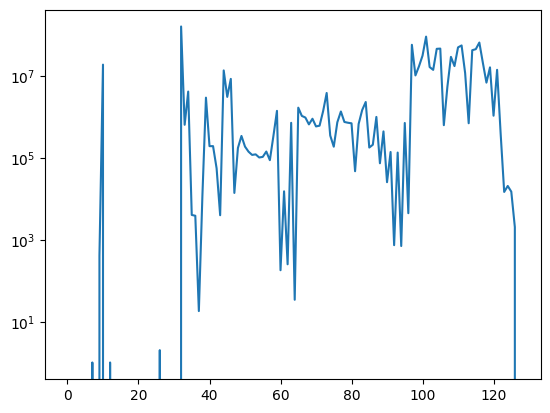

Train size: 2428
Test size: 607


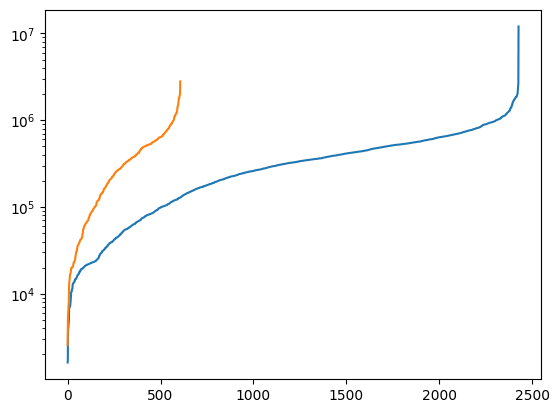

In [42]:
ids_all = torch.cat([ids for book, ids in tqdm(ds_train.items())])
print(ids_all.shape)
count = ids_all.bincount(minlength=128)
plt.plot(count)
plt.yscale('log')
plt.show()

print(f'Train size: {len(ds_train)}')
print(f'Test size: {len(ds_test)}')
a = np.array([len(ids) for ids in ds_train.values()])
plt.plot(np.sort(a))
a = np.array([len(ids) for ids in ds_test.values()])
plt.plot(np.sort(a))
plt.yscale('log')

In [18]:
for a, b in dataset.get_random_skip_batches(ds_train, 10, 32, 128, 0, 1):
    print(a.shape, b.shape)
    print(parser.ids2text(a[0]) +'|'+ parser.ids2text(b[0]))
    print('\n\n')

torch.Size([32, 128]) torch.Size([32, 128])
ox or two, and a few
sheep; not much, my lords, but still a little food."

"It is good," said I. "Infadoos; we are weary with tr|avelling through
realms of air; now let us rest."

Accordingly we entered the hut, which we found amply prepared for our
comfort



torch.Size([32, 128]) torch.Size([32, 128])
he added, turning towards the door, "we have barely a quarter of an
hour to get to the Carlton. I dare not be late. The only per|son,"
she went on, as they passed through the outer office and Arnold
paused for a moment to take down his hat and coat, "whom I



torch.Size([32, 128]) torch.Size([32, 128])
 pendulous cheeks, and a
general air of superficial benevolence which was marred by a cruel,
vicious mouth.

"There is surely so|me mistake here, gentlemen," he said in an unctuous,
make-everything-easy voice.  "I fancy that you have been misdirected.
Possi



torch.Size([32, 128]) torch.Size([32, 128])
ast with the purple and gold.

The interi

In [63]:
config = transformer.get_config('gpt-nano', n_latent_tokens=None)
print(config)
net = transformer.GPT(config)
train.train_transformer(ds_train, net, n_batches=1000, batch_size=256, seq_len=30, device='cpu', tqdm=tqdm)

{'n_vocab': 128, 'max_context_length': None, 'embd_pdrop': 0.1, 'resid_pdrop': 0.1, 'attn_pdrop': 0.1, 'n_layer': 3, 'n_head': 3, 'n_embd': 48, 'n_latent_tokens': None}


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [104]:
config = transformer.get_config('gpt-nano', n_latent_tokens=30)
# config = transformer.get_config('gpt-nano')
print(config)
net = transformer.GPT(config)


batch = torch.randint(0, 128, (32, 100))
net(batch);

{'n_vocab': 128, 'max_context_length': None, 'embd_pdrop': 0.1, 'resid_pdrop': 0.1, 'attn_pdrop': 0.1, 'n_layer': 3, 'n_head': 3, 'n_embd': 48, 'n_latent_tokens': 30}


torch.Size([32, 30, 100])


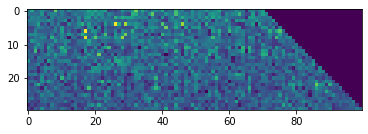

torch.Size([32, 30, 30])


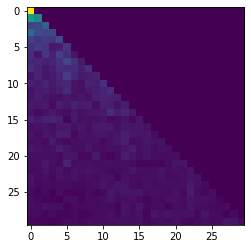

torch.Size([32, 30, 30])


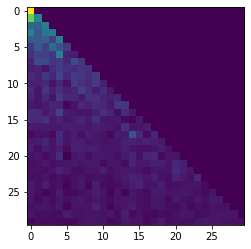

In [105]:
for block in net.blocks:
    print(block.attn_weights.shape)
    plt.imshow(block.attn_weights.detach().numpy()[0])
    plt.show()

In [152]:
config = transformer.get_config('gpt-nano')
net = longrange.LongRangeGPT(config)

batch = torch.randint(0, 128, (32, 100))
net(batch, lrr_memory=torch.randn(32, 15, 48), use_my_lrr=False);
net(batch, lrr_memory=None, use_my_lrr=False);

AttributeError: 'NoneType' object has no attribute 'shape'

torch.Size([32, 100, 100])


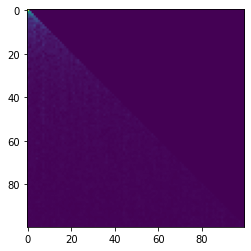

torch.Size([32, 100, 100])


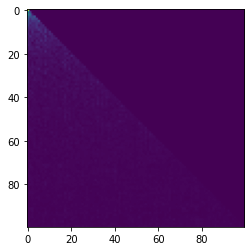

torch.Size([32, 100, 110])


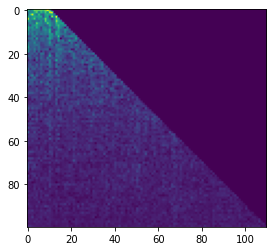

In [108]:
for block in net.blocks:
    print(block.attn_weights.shape)
    plt.imshow(block.attn_weights.detach().numpy()[0])
    plt.show()

In [109]:
train.train_longrange(ds_train, net, n_batches=1000, batch_size=32, seq_len=30, device='cpu', tqdm=tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
net(ids_book[None, :100]).shape

torch.Size([1, 100, 128])

In [19]:
a = transformer.generate(net, ids_book[None, :100], 100)
parser.ids2text(a[0])

'Agatha Christie - Murder Of Roger Ackroyd \n\nBook Jacket \n\nNone \n\n\n\nAgatha Christie - The Murder Of R.\x05NpKz\x15\x05N43kd\x1f\x153k"z\x15\tZ\x1fPz\x153(3(Pz\x7f\x058Pz\x1d\x153k"Wd\x1f\x15\x05NW\x178Pk_37.\x05NpKz\x15\t~38zppR.\x05.\x05NpKz\x1d\x1d*9U#\x1d*\x05.\x05.\x05.\x05.*9]\x06"'

In [8]:
# config = transformer.get_config('gpt-nano', n_latent_tokens=30)
config = transformer.get_config('gpt-nano')
print(config)
net = longrange.LongRangeGPT(config)

{'n_vocab': 128, 'max_context_length': None, 'embd_pdrop': 0.1, 'resid_pdrop': 0.1, 'attn_pdrop': 0.1, 'n_layer': 3, 'n_head': 3, 'n_embd': 48, 'n_latent_tokens': None}


In [9]:
logits1, lro1 = net.forward(ids_book[None, :100], calc_long_range_output=True)
logits2, lro2 = net.forward(ids_book[None, 200:300], long_range_input=lro1)
logits1.shape, logits2.shape, lro1.shape, lro2

(torch.Size([1, 100, 128]),
 torch.Size([1, 100, 128]),
 torch.Size([1, 100, 48]),
 None)

In [ ]:
config = transformer.get_config('gpt-nano')
print(config)
net = longrange.LongRangeGPT(config)
train_longrange(net, ds_train, 1000)

In [36]:
batch = next(dataset.get_random_batches(ds_train, 1, 1, 100))
print(parser.ids2text(batch))
print()
batch0, batch1 = next(dataset.get_random_skip_batches(ds_train, 1, 1, 100, 100, 200))

print(parser.ids2text(batch0))
print(parser.ids2text(batch1))

['\n\nHe pointed to a pub up a side street, and went in with Kumbo holding on\nto his arm.  The barman wa']

['t."\n\nLame Katy felt as if "a truly angel" was embracing her, and could only\nstammer out her thanks, ']
['their gifts for her to see and admire.\n\nMamma leaned down and whispered one word to the older girls;']
